# Perplexity evaluation
The goal of this project is to evaluate the perplexity of sentences generated by https://contenttool.io/random-sentence-generator/result?fileName=c2VudGVuY2Vzcw== VS those used already in research

In [1]:
pip install selenium

Note: you may need to restart the kernel to use updated packages.


In [2]:
from transformers import BertForMaskedLM, BertTokenizer
import torch
import time
import matplotlib.pyplot as plt
import numpy as np
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import ElementClickInterceptedException
from bs4 import BeautifulSoup
from tqdm import tqdm
import random

In [3]:
def calculate_perplexity(sentence):
    model_name = 'bert-base-uncased'  # Pre-trained BERT model
    tokenizer = BertTokenizer.from_pretrained(model_name)
    model = BertForMaskedLM.from_pretrained(model_name)

    input_ids = tokenizer.encode(sentence, add_special_tokens=True, return_tensors='pt')
    with torch.no_grad():
        outputs = model(input_ids)
        prediction_scores = outputs.logits

    loss = torch.nn.CrossEntropyLoss(reduction='none')
    token_ids = input_ids.squeeze(0)
    token_scores = prediction_scores.squeeze(0)
    loss = loss(token_scores[:-1], token_ids[1:]).mean()

    perplexity = torch.exp(loss)

    return perplexity.item()

## Load Data

In [16]:
def scrapper(n=50):
    sentences = []
    
    # Configure Selenium webdriver
    chrome_options = Options()
    chrome_options.add_argument("--headless")  # Run Chrome in headless mode (no GUI)
    driver = webdriver.Chrome(options=chrome_options)

    # Open the URL
    url = "https://contenttool.io/random-sentence-generator/result?fileName=c2VudGVuY2Vzcw=="
    driver.get(url)

    # Wait for the page to load
    wait = WebDriverWait(driver, 10)
    wait.until(EC.presence_of_element_located((By.ID, "results2")))

    # Scrape and print the initial content
    soup = BeautifulSoup(driver.page_source, "html.parser")
    initial_content = soup.find(id="results2").get_text()
    # print(f"First Sentence:\n{initial_content}\n")

    # Click the "Generate Sentence" button in a loop of length 50
    for _ in tqdm(range(n)):
        try:
            # Find and click the button
            button = driver.find_element(By.ID, "btn")
            button.click()

            # Wait for the new content to load
            time.sleep(10)  # Adjust the sleep duration if needed

            # Scrape and print the updated content
            soup = BeautifulSoup(driver.page_source, "html.parser")
            updated_content = soup.find(id="results2").get_text()
            #print(f"New Sentence:\n{updated_content}\n")

            sentences.append(updated_content)
        except ElementClickInterceptedException:
            continue

    # Close the webdriver
    driver.quit()
    return sentences

def save_sentences_to_file(sentences, file_path):
    with open(file_path, 'a') as file:
        for sentence in sentences:
            file.write(sentence + '\n')

In [6]:
# Data from website
for _ in range(100):
    scrapped_sentences = scrapper(10)
    file_path = 'scrapped_SIT.txt'
    save_sentences_to_file(scrapped_sentences, file_path)

100%|██████████| 10/10 [01:41<00:00, 10.17s/it]


TimeoutException: Message: timeout: Timed out receiving message from renderer: 299.603
  (Session info: headless chrome=113.0.5672.127)
Stacktrace:
Backtrace:
	GetHandleVerifier [0x00D98893+48451]
	(No symbol) [0x00D2B8A1]
	(No symbol) [0x00C35058]
	(No symbol) [0x00C282BF]
	(No symbol) [0x00C2810C]
	(No symbol) [0x00C26D46]
	(No symbol) [0x00C275CA]
	(No symbol) [0x00C30135]
	(No symbol) [0x00C3C2B8]
	(No symbol) [0x00C3F1B6]
	(No symbol) [0x00C279E3]
	(No symbol) [0x00C3C189]
	(No symbol) [0x00C8C67F]
	(No symbol) [0x00C7A0B6]
	(No symbol) [0x00C57E08]
	(No symbol) [0x00C58F2D]
	GetHandleVerifier [0x00FF8E3A+2540266]
	GetHandleVerifier [0x01038959+2801161]
	GetHandleVerifier [0x0103295C+2776588]
	GetHandleVerifier [0x00E22280+612144]
	(No symbol) [0x00D34F6C]
	(No symbol) [0x00D311D8]
	(No symbol) [0x00D312BB]
	(No symbol) [0x00D24857]
	BaseThreadInitThunk [0x76DA00C9+25]
	RtlGetAppContainerNamedObjectPath [0x77B87B4E+286]
	RtlGetAppContainerNamedObjectPath [0x77B87B1E+238]


In [14]:
# Data from research database
def parse_text_file(file_path):
    lines = []
    with open(file_path, 'r') as file:
        for line in file:
            lines.append(line.strip())  # Remove leading/trailing whitespace and newline characters
    return lines

# Example usage:
old_sentences = parse_text_file('sitsent.txt')
new_sentences = parse_text_file('scrapped_SIT.txt')
print(len(old_sentences), "old sentences found")
print(len(new_sentences), "new sentences found")

1089 old sentences found
4299 new sentences found


In [11]:
def calculate_duplicate_proportion(sentences):
    total_sentences = len(sentences)
    unique_sentences = set(sentences)
    num_duplicates = total_sentences - len(unique_sentences)
    duplicate_proportion = num_duplicates / total_sentences
    return duplicate_proportion
proportion = calculate_duplicate_proportion(new_sentences)
print("Proportion of duplicates in new sentences: {:.2f}%".format(proportion * 100))

Proportion of duplicates in new sentences: 53.97%


In [12]:
save_sentences_to_file(set(new_sentences),'unique_SIT.txt')

## Extract Perplexity

In [15]:
perplexity_scrapped = []
for sentence in tqdm(list(set(new_sentences))[:50]):
    perplexity_scrapped.append(calculate_perplexity(sentence))
    
mean_scrapped = np.mean(np.array(perplexity_scrapped))
print(f"Mean perplexity score for scrapped sentences is: {mean_scrapped}")

  0%|          | 0/50 [00:00<?, ?it/s]Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
  2%|▏         | 1/50 [00:05<04:13,  5.17s/it]Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task o

 26%|██▌       | 13/50 [01:37<04:43,  7.65s/it]Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
 28%|██▊       | 14/50 [01:45<04:42,  7.84s/it]Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on anot

 74%|███████▍  | 37/50 [05:03<01:52,  8.62s/it]Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
 76%|███████▌  | 38/50 [05:10<01:36,  8.06s/it]Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on anot

Mean perplexity score for scrapped sentences is: 20601073.465


In [16]:
perplexity_old = []
random_ints = random.sample(range(0, len(old_sentences)), 50)
for sentence in tqdm(old_sentences[-50:]):# tqdm([old_sentences[i] for i in random_ints]):
    perplexity_old.append(calculate_perplexity(sentence))
mean_old = np.mean(np.array(perplexity_old))

print(f"Mean perplexity score for old sentences is: {mean_old}")

  0%|          | 0/50 [00:00<?, ?it/s]Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
  2%|▏         | 1/50 [00:08<06:47,  8.31s/it]Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task o

 26%|██▌       | 13/50 [01:56<05:53,  9.56s/it]Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
 28%|██▊       | 14/50 [02:08<06:09, 10.26s/it]Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on anot

 74%|███████▍  | 37/50 [05:30<01:52,  8.68s/it]Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
 76%|███████▌  | 38/50 [05:39<01:46,  8.84s/it]Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on anot

Mean perplexity score for old sentences is: 12154079.38625


In [ ]:
y = np.array(perplexity_scrapped)

# create a box and whiskers plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.boxplot(y)

# calculate the mean and standard deviation
mean_value = np.mean(y)
std_dev = np.std(y)

# plot the mean as a red line
ax.axhline(mean_value, color='red', linestyle='--', label='Mean')

# plot the standard deviation as blue lines
ax.axhline(mean_value + std_dev, color='blue', linestyle='--', label='Standard Deviation')
ax.axhline(mean_value - std_dev, color='blue', linestyle='--')

# set the axis labels and title
ax.set_xlabel('Perplexity')
ax.set_ylabel('amount')
ax.set_title('Perplexity for scrapped sentences')

# add a legend
ax.legend()

plt.show()

In [ ]:
y = np.array(perplexity_old)

# create a box and whiskers plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.boxplot(y)

# calculate the mean and standard deviation
mean_value = np.mean(y)
std_dev = np.std(y)

# plot the mean as a red line
ax.axhline(mean_value, color='red', linestyle='--', label='Mean')

# plot the standard deviation as blue lines
ax.axhline(mean_value + std_dev, color='blue', linestyle='--', label='Standard Deviation')
ax.axhline(mean_value - std_dev, color='blue', linestyle='--')

# set the axis labels and title
ax.set_xlabel('Perplexity')
ax.set_ylabel('amount')
ax.set_title('Perplexity for SIT sentences')

# add a legend
ax.legend()

plt.show()

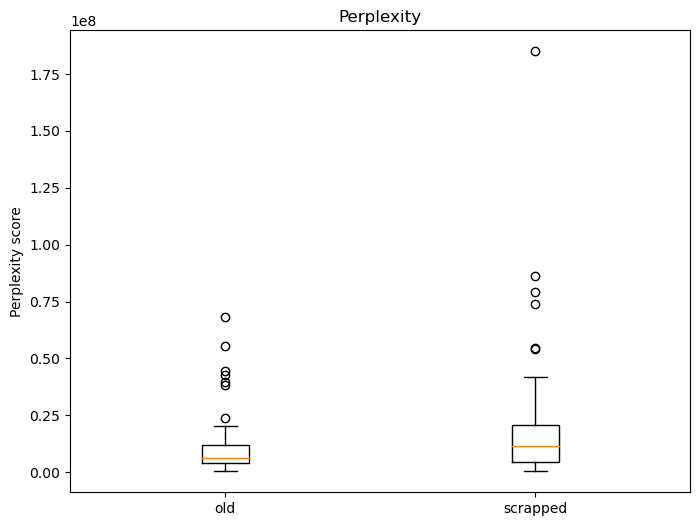

In [17]:
# create a box and whiskers plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.boxplot([perplexity_old, perplexity_scrapped], labels=["old","scrapped"])

# set the axis labels and title
ax.set_ylabel('Perplexity score')
ax.set_title('Perplexity of SIT sentences')

plt.show()

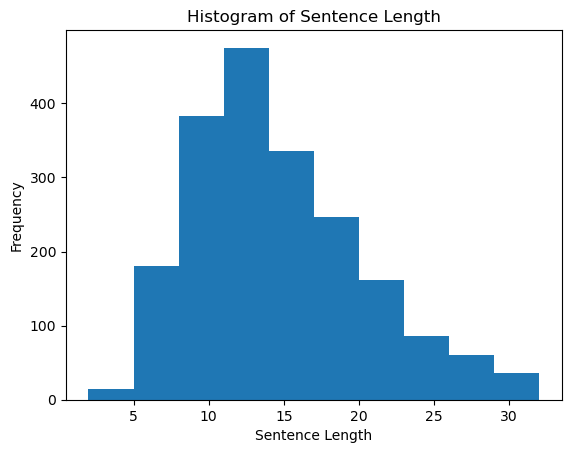

In [19]:
def plot_sentence_length_histogram(sentences):
    lengths = [len(sentence.split(' ')) for sentence in sentences]
    plt.hist(lengths, bins=10)  # You can adjust the number of bins as desired
    plt.xlabel('Sentence Length')
    plt.ylabel('Frequency')
    plt.title('Histogram of Sentence Length')
    plt.show()

# Example usage:
plot_sentence_length_histogram(list(set(new_sentences)))

## Merge and sort by length

In [15]:
total_sentences = list(set(new_sentences)) + old_sentences
total_sentences = sorted(total_sentences, key=lambda x: len(x.split()))

In [17]:
save_sentences_to_file(total_sentences,'all_SIT.txt')